# internal note v 3.3 Aug-20, 2017

In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
%matplotlib inline

# pp-SRC c.m. analysis

In [2]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_noPrecFid , data300Pmiss600_noPrecFid = dict() , dict()
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()

for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

In [3]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials","NoPrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    cm_pars['sigma_t_before_acc_corr'] = 0.5*(cm_pars['sigma_x_unweighted']+cm_pars['sigma_y_unweighted'])
    cm_pars['sigma_t_before_acc_corr_err'] = 0.5*np.sqrt(np.square(cm_pars['sigma_x_before_acc_corr_err'])+np.square(cm_pars['sigma_y_before_acc_corr_err']))
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars

## cm_parameters['PrecFiducials']

In [4]:
cm_parameters['PrecFiducials'][['sigma_x_unweighted','sigma_xErr_unweighted','sigma_y_unweighted','sigma_yErr_unweighted','sigma_z_unweighted','sigma_zErr_unweighted','chi2red_x_unweighted']]

,sigma_x_unweighted,sigma_xErr_unweighted,sigma_y_unweighted,sigma_yErr_unweighted,sigma_z_unweighted,sigma_zErr_unweighted,chi2red_x_unweighted
0,0.158378,0.006865,0.161638,0.007007,0.147251,0.006384,0.602767
1,0.181341,0.013666,0.166910,0.012570,0.141058,0.010629,1.058674
2,0.178723,0.008388,0.185658,0.008706,0.150658,0.007069,0.471936
3,0.196040,0.020634,0.164304,0.017300,0.169545,0.017832,0.847317


In [5]:
simulation_results = dict()
for Fiducials in ["PrecFiducials"]:
    for target in ['C','Al','Fe','Pb']:#{
            test_name = "sims_300Pmiss600_"+target+"_"+Fiducials
            simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/results_300Pmiss600/"+test_name+'.csv')
            simulation_results[test_name].fillna(-1,inplace=True)
            print len(simulation_results[test_name]),'events in ',test_name

24300 events in  sims_300Pmiss600_C_PrecFiducials
24196 events in  sims_300Pmiss600_Al_PrecFiducials
24150 events in  sims_300Pmiss600_Fe_PrecFiducials
19921 events in  sims_300Pmiss600_Pb_PrecFiducials


In [7]:
Fiducials = "PrecFiducials"
for extraname in ["_mean75MeVc_sigma50MeVc","_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured"]:
    for target in ['C','Al','Fe','Pb']:#{
        test_name = "sims_300Pmiss600_"+target+"_"+Fiducials+extraname
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/results_300Pmiss600/"+test_name+'.csv')
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

12150 events in  sims_300Pmiss600_C_PrecFiducials_mean75MeVc_sigma50MeVc
12150 events in  sims_300Pmiss600_Al_PrecFiducials_mean75MeVc_sigma50MeVc
12150 events in  sims_300Pmiss600_Fe_PrecFiducials_mean75MeVc_sigma50MeVc
12150 events in  sims_300Pmiss600_Pb_PrecFiducials_mean75MeVc_sigma50MeVc
12150 events in  sims_300Pmiss600_C_PrecFiducials_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured
12150 events in  sims_300Pmiss600_Al_PrecFiducials_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured
12150 events in  sims_300Pmiss600_Fe_PrecFiducials_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured
12150 events in  sims_300Pmiss600_Pb_PrecFiducials_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured


In [8]:
def find_x_poly(poly,y0,xmin=0,xmax=0.3):
    p = np.poly1d(poly)
    roots = (p - y0).roots
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly

In [9]:
def plot_cm_direction(simulations_results=None
                      ,Fiducials='PrecFiducials'
                      ,extraname=""
                      ,ax=None,A=12
                      ,poly_degree=3
                      ,confidence_interval = 0.68
                      ,direction='x',colors=['blue','royalblue'],s=50
                      ,debug=0):

    gen,rec = simulations_results['gen_Sigma_t'],simulations_results['rec_sigma_'+direction]
    plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if debug:  print "plt.scatter()"
    # fit a polynomial of order 2
    popt,cov = np.polyfit( gen,rec , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),1000)
    poly = np.poly1d(popt)
    ax.plot(x,poly(x),'-',color='black',linewidth=2,label='best fit')    
    
    # Convert to percentile point of the normal distribution [https://en.wikipedia.org/wiki/Standard_score]
    pp = (1. + confidence_interval) / 2.
    # Convert to number of standard deviations.
    nstd = stats.norm.ppf(pp)
    
    # Add nstd standard deviations to parameters to obtain the upper confidence interval
    poly_up = np.poly1d(popt + nstd * perr)
    ax.plot(x,poly_up(x),'-',color='gray',linewidth=2)
    poly_dw = np.poly1d(popt - nstd * perr)
    ax.plot(x,poly_dw(x),'-',color='gray',linewidth=2)
    
    cm_pars = cm_parameters[Fiducials]    
    cm_pars_target = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    # reconstructed \sigma in data
    if debug:  print cm_pars_target
    sigma_meas, sigma_meas_err = float(cm_pars_target['sigma_'+direction+'_before_acc_corr']), float(cm_pars_target['sigma_'+direction+'_before_acc_corr_err'])
    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    label_corr = '$%.3f$'%(corr_value)
    plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)
    
    plt.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    plt.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # systematical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_sys = find_x_poly(poly_dw,sigma_meas+sigma_meas_err)
    x_poly_dw_sys = find_x_poly(poly_up,sigma_meas-sigma_meas_err)
    corr_val_up_err_sys = x_poly_up_sys - x_poly_up_stat
    corr_val_dw_err_sys = x_poly_dw_stat - x_poly_dw_sys
    label_unc_sys = '$(^{+%.0f}_{-%.0f})_{sys.}$'%(1000*corr_val_up_err_sys,1000*corr_val_dw_err_sys)



    if debug:  print "plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000)..."   
    # projection of the measured uncertainties
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_sys,1000) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_sys,1000) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    # projection of the systematical uncertainties
    plt.plot( [x_poly_up_sys,x_poly_up_sys] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='grey' ,linestyle='-')
    plt.plot( [x_poly_dw_sys,x_poly_dw_sys] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    if debug:  print "plugging",'sigma_'+direction+'_corrected'+extraname
    
    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_up_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_dw_err_sys))
    
    plt.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[0]
             ,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
        
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value)
    
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_sys'+extraname,corr_val_up_err_sys)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_sys'+extraname,corr_val_dw_err_sys)

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
             
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0,0.05,0.1,0.15,0.2,0.25,0.3] , yticks=[0,0.05,0.1,0.15,0.2,0.25,0.3] , do_add_grid=True 
             ,title = cm_pars_target['target'].to_string(index=False) + ', $'+direction+'-direction$ ('+Fiducials+')')

    ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    ax.set_xlim(0,0.3);ax.set_ylim(0,0.3);
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

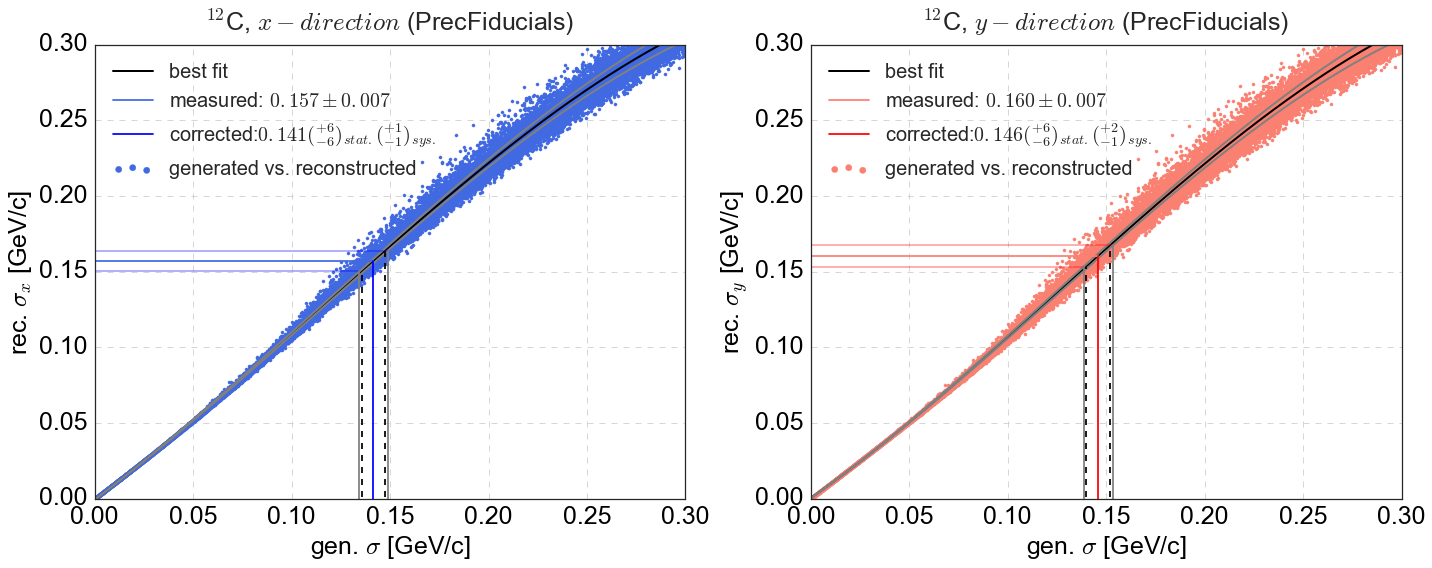

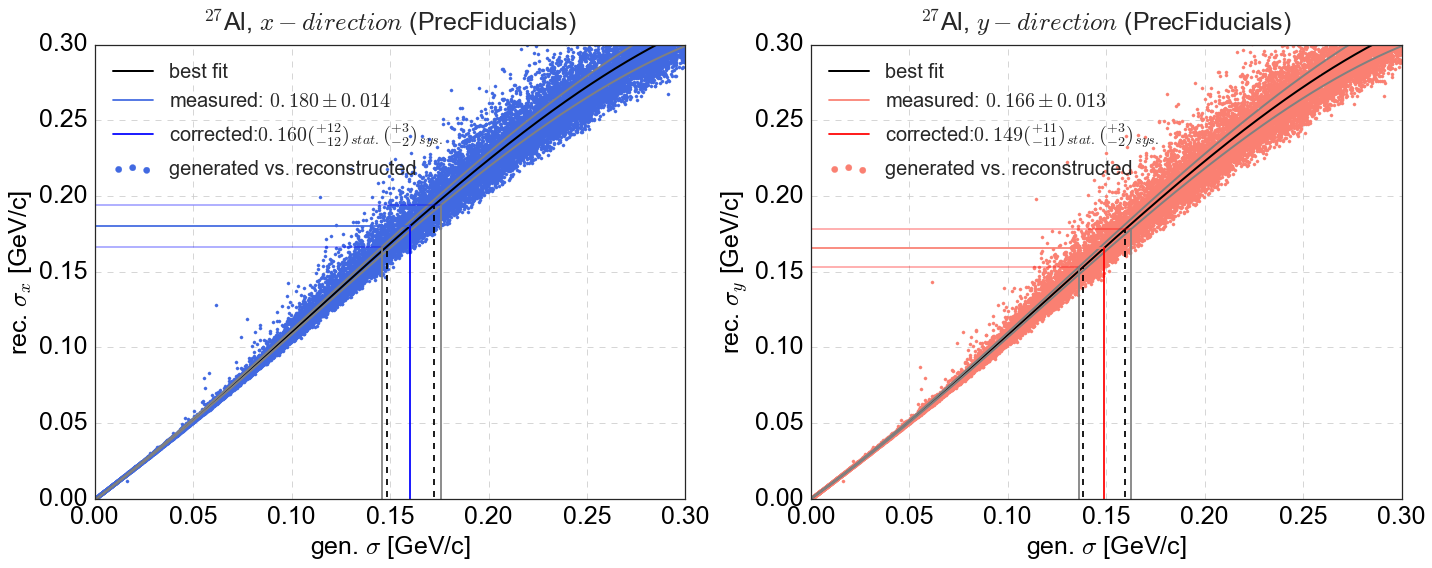

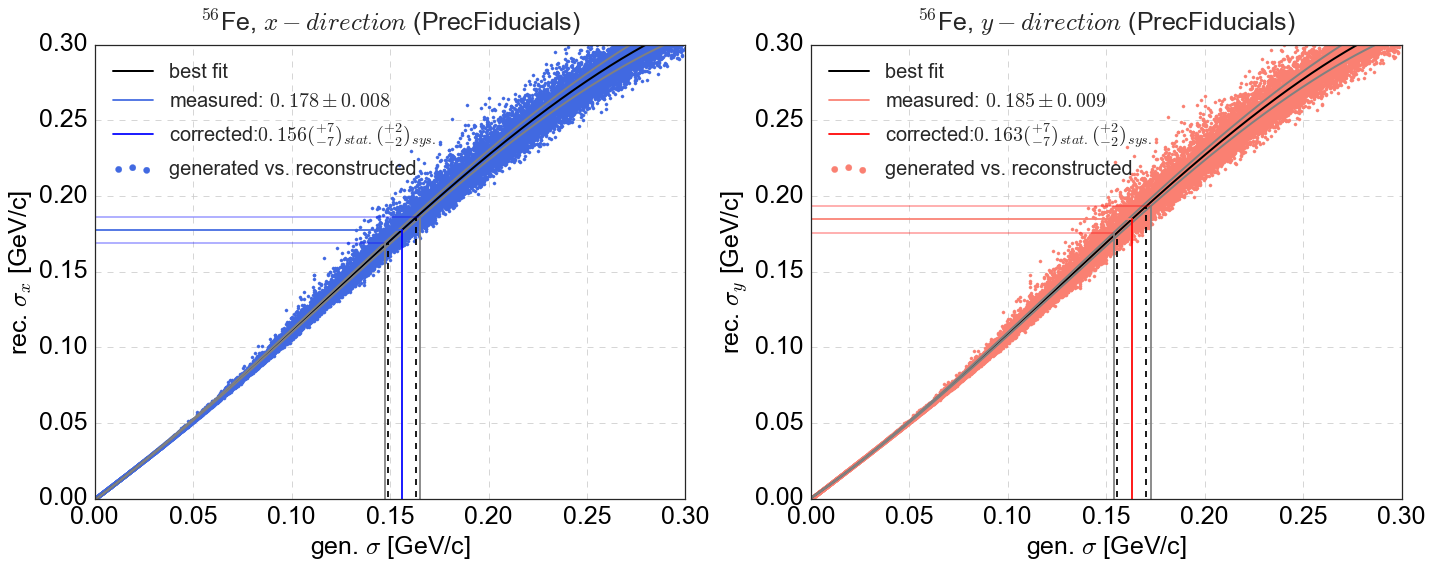

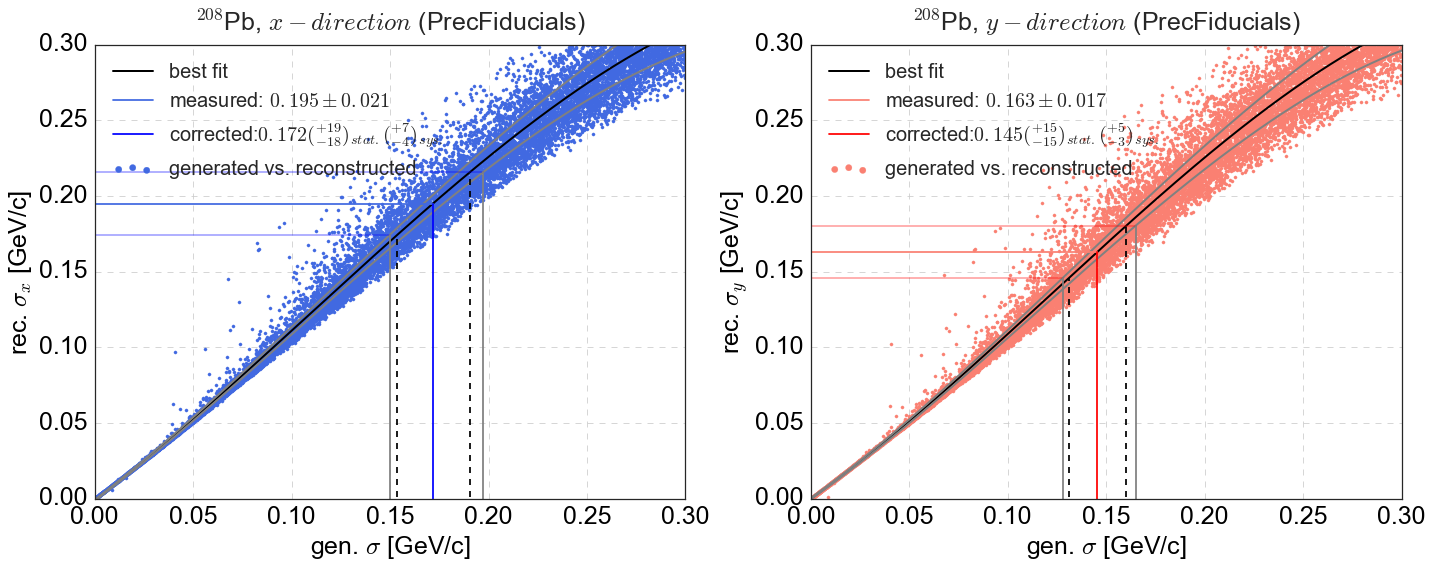

In [11]:
poly_degree = 3 # fit polynomial degree
confidence_interval = 0.68 # band around fit

for Fiducials in ["PrecFiducials"]:#,"NoPrecFiducials"]: 
    for A,target,Neep,Neepp in zip([12,27,56,208]
                                   ,['C','Al','Fe','Pb']
                                   ,[7598,2573,8558,2635]
                                   ,[266,88,227,45]
                       ):#{
#     for A,target,Neep,Neepp in zip([56,208],['Fe','Pb'],[8558,2635],[227,45]):#{
        test_name = "sims_300Pmiss600_"+target+"_"+Fiducials
        simulations_results=simulation_results[test_name]
        good_results = simulations_results[(simulations_results['gen_SigmaZ']>0)
                                           &(simulations_results['rec_sigma_x']>0)
                                           &(simulations_results['rec_sigma_y']>0)                                                                                    
                                           &(simulations_results['rec_sigma_z']>0)
                                           &(simulations_results['rec_mean_x']>-0.9)
                                           &(simulations_results['rec_mean_y']>-0.9)                                                                                   
                                           &(simulations_results['rec_mean_x']>-0.9)
#                                            &(simulations_results['Naccepted']>0.1*20*(Neep+Neepp))
                                           &(simulations_results['gen_MeanZ']<0.3)
                                          ]
        fig=plt.figure(figsize=(20,8))
    
        ax=fig.add_subplot(1,2,1)    
        corr_sx = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials                                                           
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='x'                                                           
                                                           ,colors=['blue','royalblue']);

        ax=fig.add_subplot(1,2,2)    
        corr_sx = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials                                                                                                                                                                                 
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='y'                                                           
                                                           ,colors=['red','salmon']);                        
    
        plt.tight_layout()   

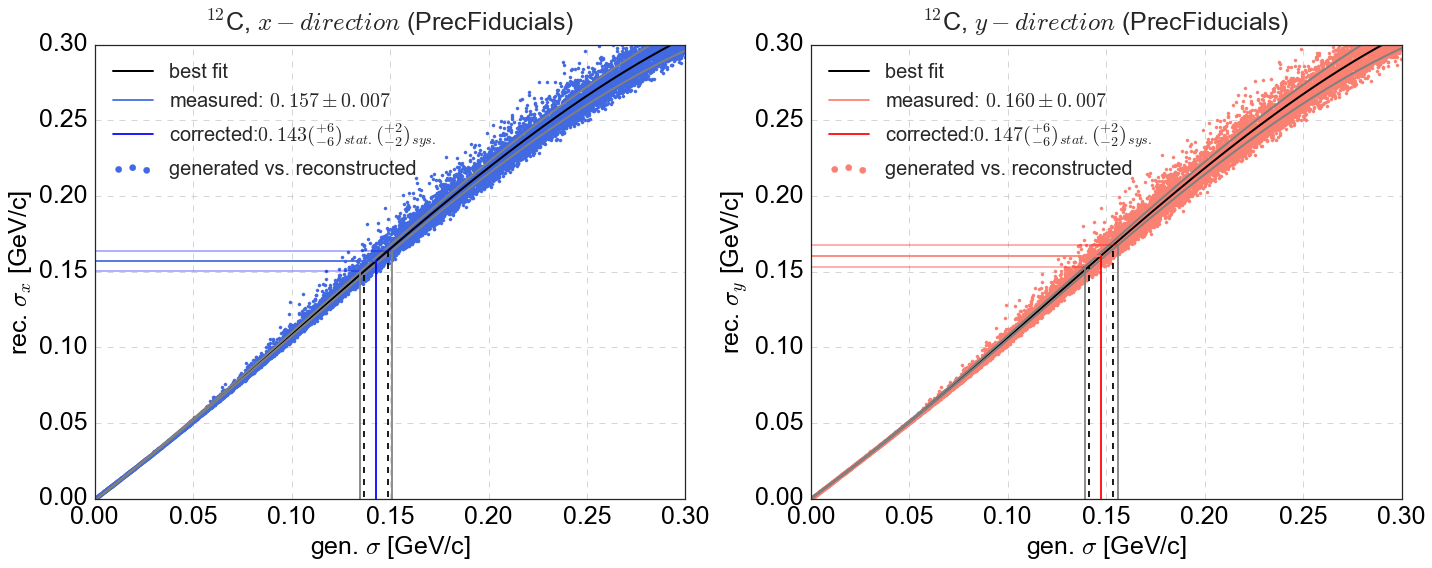

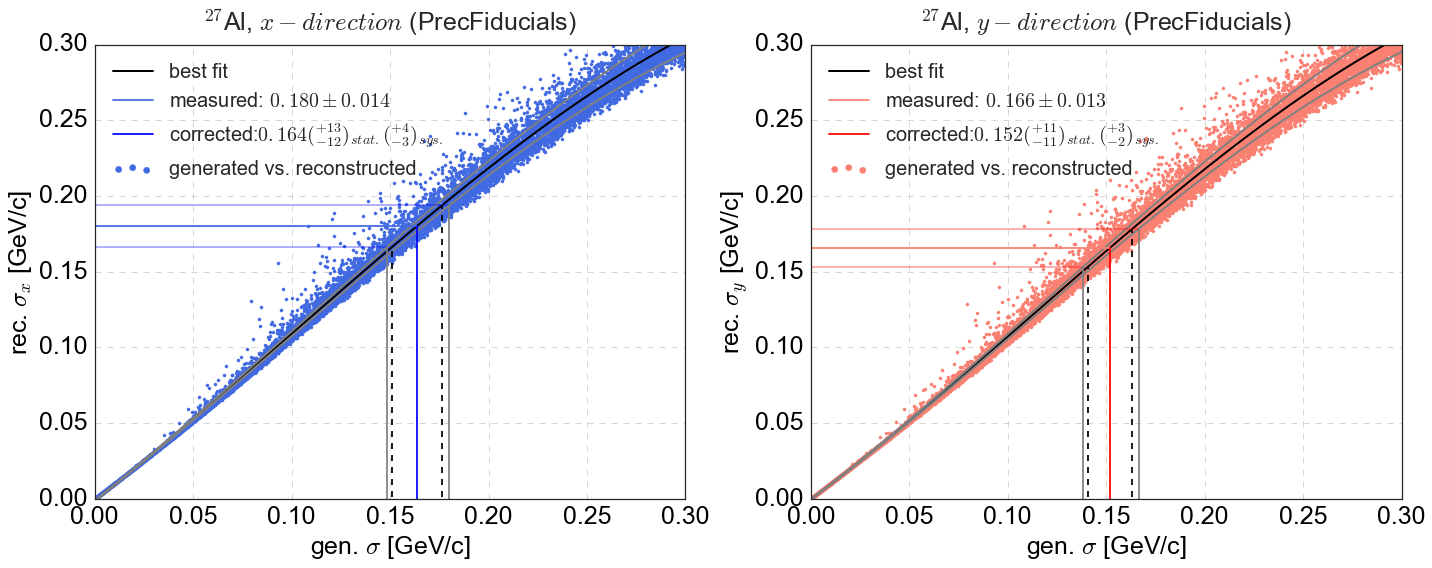

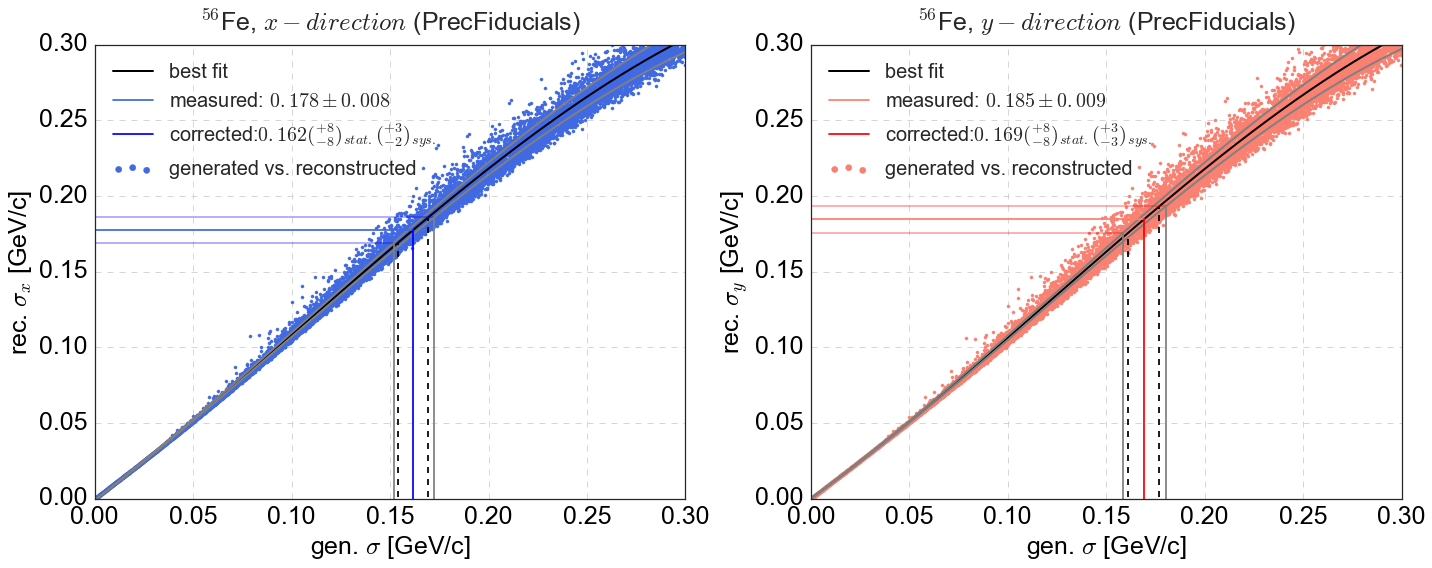

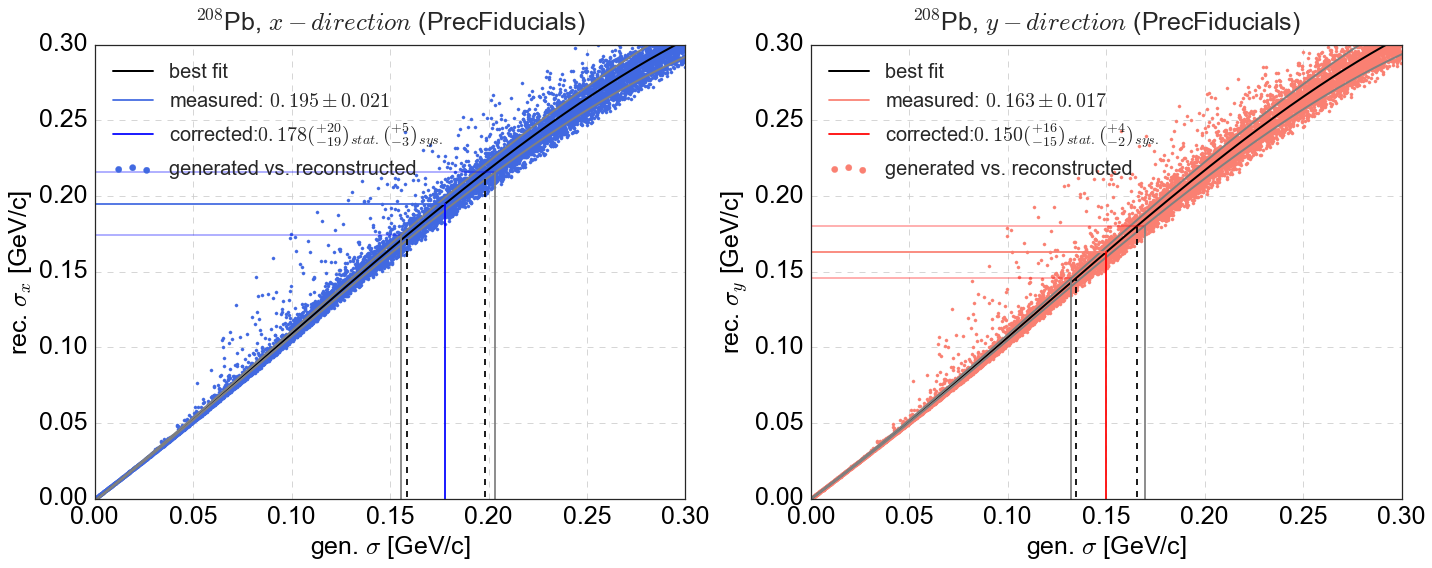

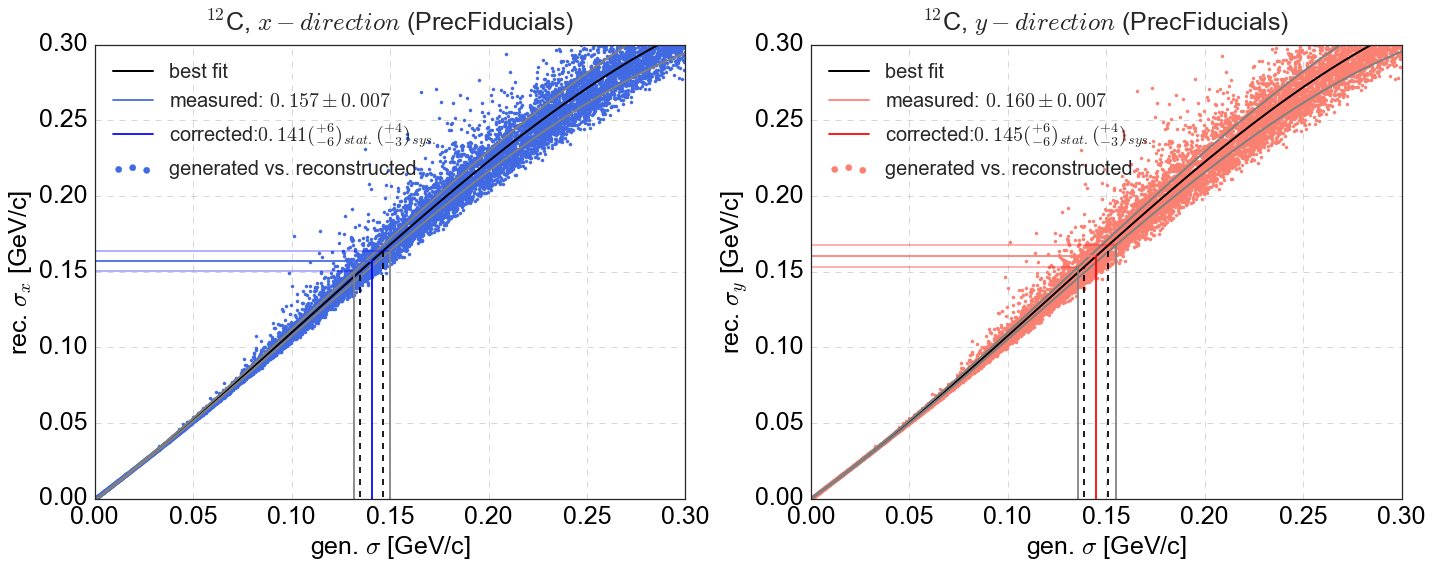

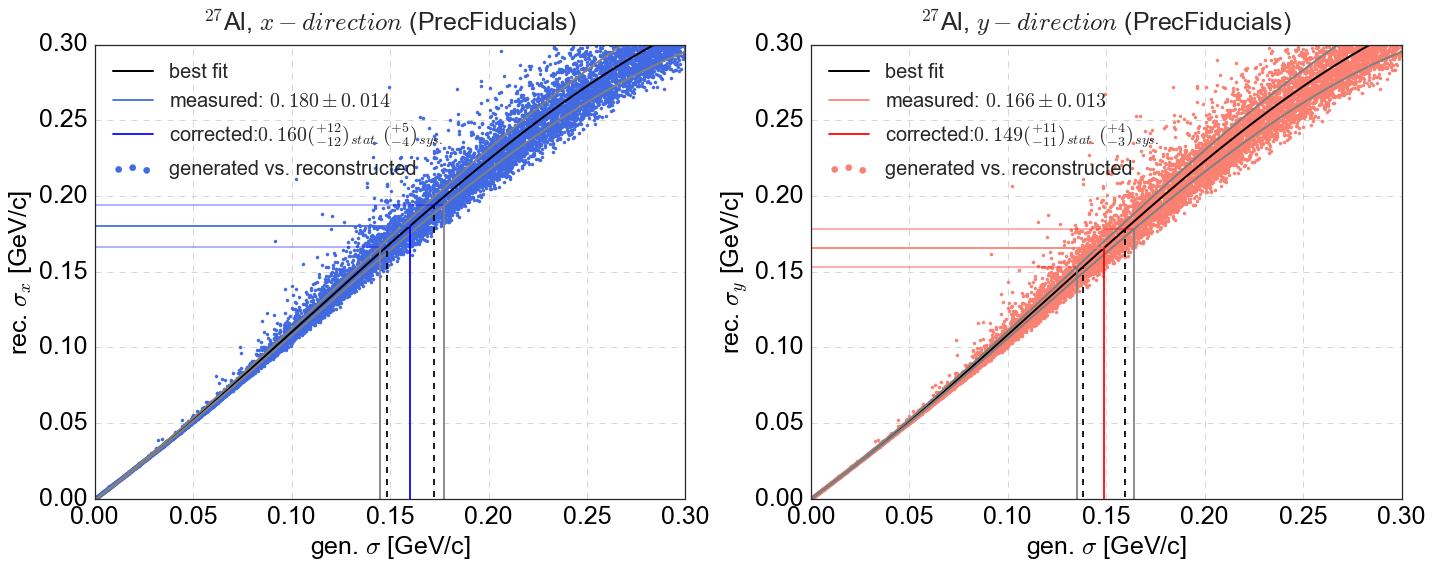

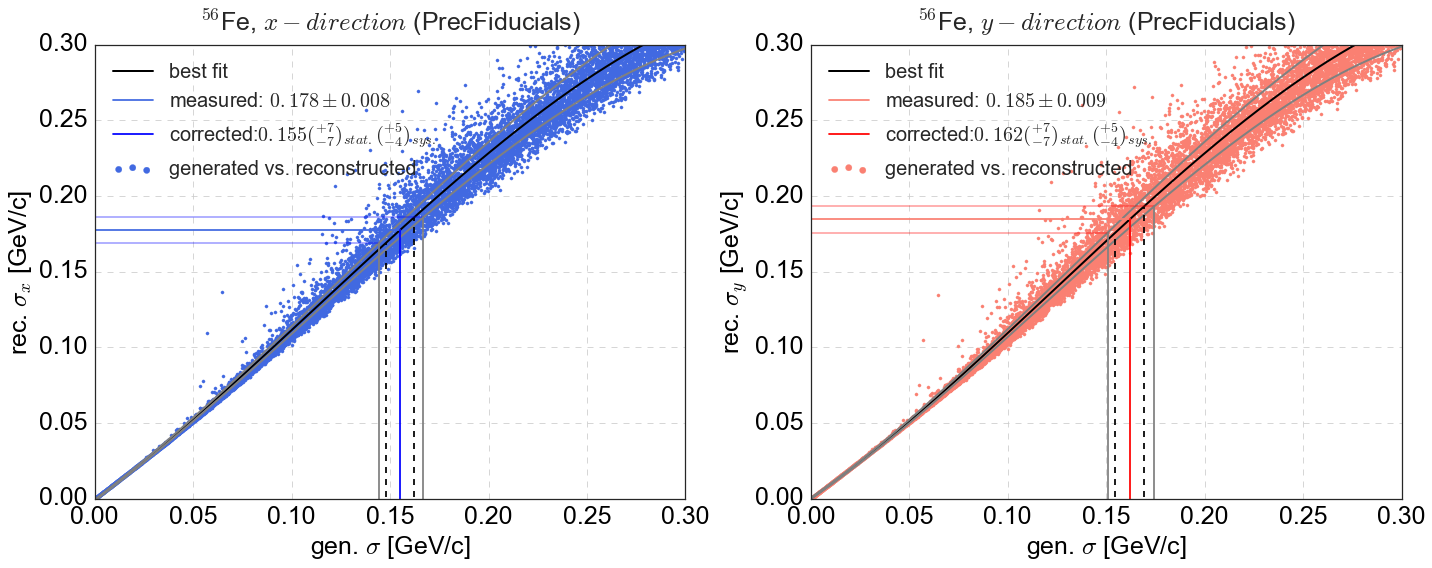

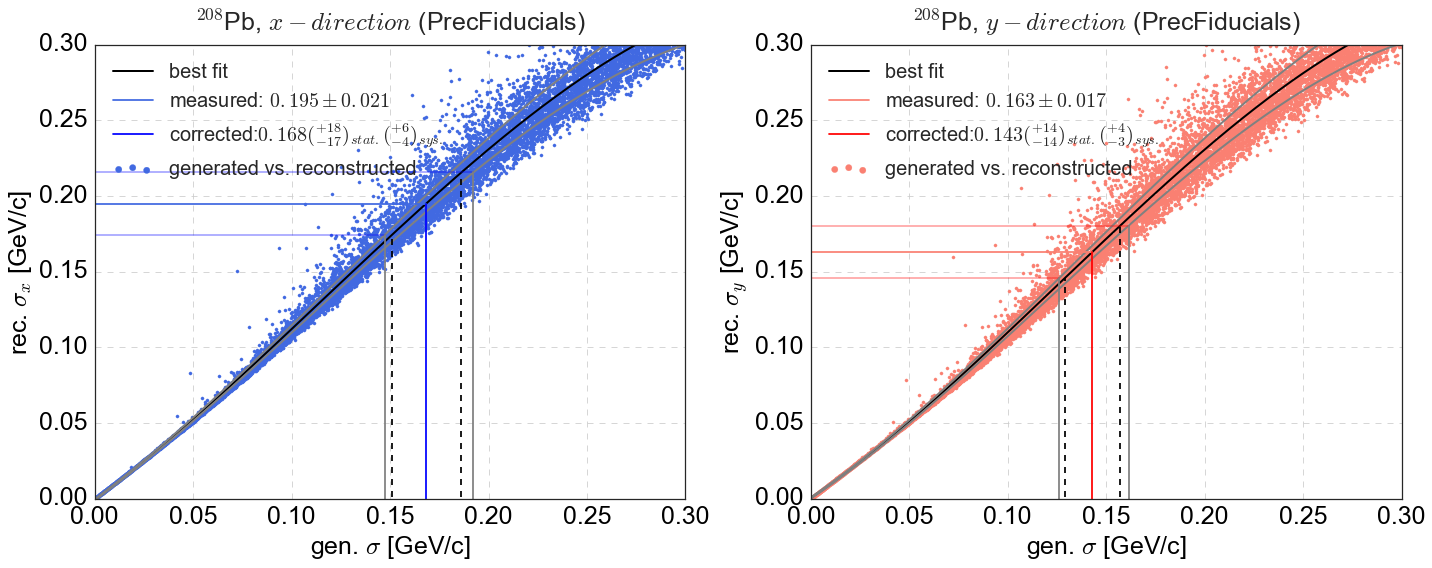

In [13]:
poly_degree = 3 # fit polynomial degree
confidence_interval = 0.68 # band around fit
Fiducials = "PrecFiducials"
for extraname in ["_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured","_mean75MeVc_sigma50MeVc"]:

    for A,target in zip([12,27,56,208]
                        ,['C','Al','Fe','Pb']
                       ):#{
        test_name = "sims_300Pmiss600_"+target+"_"+Fiducials+extraname
        simulations_results=simulation_results[test_name]
        good_results = simulations_results[(simulations_results['gen_SigmaZ']>0)
                                           &(simulations_results['rec_sigma_x']>0)
                                           &(simulations_results['rec_sigma_y']>0)                                                                                    
                                           &(simulations_results['rec_sigma_z']>0)
                                           &(simulations_results['rec_mean_x']>-0.9)
                                           &(simulations_results['rec_mean_y']>-0.9)                                                                                   
                                           &(simulations_results['rec_mean_x']>-0.9)
#                                            &(simulations_results['Naccepted']>7*(Neep+Neepp))
                                          ]
        fig=plt.figure(figsize=(20,8))
    
        ax=fig.add_subplot(1,2,1)    
        corr_sx = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials
                                                           ,extraname=extraname                                                                                                                
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='x'                                                           
                                                           ,colors=['blue','royalblue']);

        ax=fig.add_subplot(1,2,2)    
        corr_sy = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials  
                                                           ,extraname=extraname
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='y'                                                           
                                                           ,colors=['red','salmon']);                        
    
        plt.tight_layout()   

In [14]:
for Fiducials in ['PrecFiducials']:#,'NoPrecFiducials']:
    sample = cm_parameters_with_correction[Fiducials]
    for direction in ['x','y']:
        sample['sigma_'+direction+'_final'] = sample['sigma_'+direction+'_corrected']
        for updw in ['up','dw']:
            sample['sigma_'+direction+'_final_'+updw+'_err_tot'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot']
            sample['sigma_'+direction+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_final_'+updw+'_err_tot']

    sample['sigma_t_corrected'] = 0.5*(sample['sigma_x_corrected']+sample['sigma_y_corrected'])
    sample['sigma_t_final'] = 0.5*(sample['sigma_x_corrected']+sample['sigma_y_corrected'])

    for err_label in ['stat','sys','tot']:
        for updw in ['up','dw']:
            sample['sigma_t_final_'+updw+'_err_'+err_label] = 0.5*np.sqrt(np.square(sample['sigma_x_corrected_'+updw+'_err_'+err_label])                                                                              
                                                                          +np.square(sample['sigma_y_corrected_'+updw+'_err_'+err_label]))
    for updw in ['up','dw']:
        sample['sigma_t_final_'+updw+'_err'] = sample['sigma_t_final_'+updw+'_err_tot']

Fiducials = "PrecFiducials"
sample = cm_parameters_with_correction[Fiducials]
for extraname in ["_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured","_mean75MeVc_sigma50MeVc"]:
    for direction in ['x','y']:
        sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
        for updw in ['up','dw']:
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot']

    sample['sigma_t'+extraname+'_corrected'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])
    sample['sigma_t'+extraname+'_final'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])

    for err_label in ['stat','sys','tot']:
        for updw in ['up','dw']:
            sample['sigma_t'+extraname+'_final_'+updw+'_err_'+err_label] = 0.5*np.sqrt(np.square(sample['sigma_x_corrected_'+updw+'_err_'+err_label+extraname])                                                                         
                                                                                       +np.square(sample['sigma_y_corrected_'+updw+'_err_'+err_label+extraname]))
    for updw in ['up','dw']:
        sample['sigma_t'+extraname+'_final_'+updw+'_err'] = sample['sigma_t_final_'+updw+'_err_tot']

In [22]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
                                                ,'sigma_t_final'
                                                ,'sigma_t_final_up_err_stat','sigma_t_final_dw_err_stat'
                                                ,'sigma_t_final_up_err_sys','sigma_t_final_dw_err_sys'
                                                ,'sigma_t_final_up_err_tot','sigma_t_final_dw_err_tot']].astype(float)

,sigma_t_before_acc_corr,sigma_t_before_acc_corr_err,sigma_t_final,sigma_t_final_up_err_stat,sigma_t_final_dw_err_stat,sigma_t_final_up_err_sys,sigma_t_final_dw_err_sys,sigma_t_final_up_err_tot,sigma_t_final_dw_err_tot
0,0.160008,0.004905,0.143676,0.004254,0.004236,0.000643,0.000548,0.004303,0.004271
1,0.174126,0.009284,0.154648,0.008146,0.008038,0.001389,0.001022,0.008264,0.008102
2,0.182190,0.006045,0.159496,0.005165,0.005117,0.000944,0.000776,0.005251,0.005176
3,0.180172,0.013463,0.158651,0.011879,0.011593,0.002760,0.001726,0.012196,0.011721


# add calculations...

In [15]:
ColleCalc = pd.DataFrame({'A':[4,12 , 27 , 56 , 208],
                        'allpairs':[110,141,146,147.5,145.5],# average of HO and WS
                        'nl00':[110,157,166,173.,177.5]},# average of HO and WS
                         index = ['$^{4}$He','$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
CiofiCalc = pd.DataFrame({'A':[4 , 12 , 40 , 56 , 208], # 3 , 
                        's_t':[90 , 138.6174 , 142.6555 , 132.5117 , 151.3311]}, # 0.0724
                         index = ['$^{4}$He','$^{12}$C','$^{40}$Ca','$^{56}$Fe','$^{208}$Pb']) # '$^{3}$He',
MonizCalc = pd.DataFrame({'A':[12 , 40 , 208],
                        '3kF/4':[165.8 , 188.3 , 198.8]},
                         index = ['$^{12}$C','$^{40}$Ca','$^{208}$Pb'])

BNL_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.143],'sigma_t_final_Err':[0.017]},index = ['$^{12}$C'])
HallA_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.136],'sigma_t_final_Err':[0.020]},index = ['$^{12}$C'])
Korover_Data = pd.DataFrame({'A':[4],'sigma_t_final':[0.100],'sigma_t_final_Err':[0.020]},index = ['$^{4}$He'])

WI_Data = pd.DataFrame({'A':[ 12 , 27 , 56 , 208], 
                        'sigma_t_final':[0.158 , 0.156 , 0.181 , 0.174], 
                        'sigma_t_final_Err':[0.012 , 0.019 , 0.011 , 0.016]}, 
                         index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']) 

In [16]:
from scipy.interpolate import interp1d, Akima1DInterpolator,BarycentricInterpolator,splprep

def plot_data(data , ax=None, direction='t', Ashift=0, fmt='o', marker='^',color='red',
                       markersize=15, linewidth=4, 
                       vary=None , varyerr=None , label=None , facecolors=None ):
    ax.errorbar((data['A']+Ashift), 
                y=1000*data['sigma_'+direction+'_final'],
                yerr=1000*data['sigma_'+direction+'_final_Err'],                
                color=color, marker=marker,markersize=markersize,linewidth=linewidth
                , fmt=fmt,label=label)

def plot_data_assymetric(data , ax=None, direction='t', Ashift=0, fmt='o', marker='^',color='red',
                       markersize=15, linewidth=4, 
                       vary=None , varyerr=None , label=None , facecolors=None ):
    ax.errorbar((data['A']+Ashift), 
                y=1000*data['sigma_'+direction+'_final'],
                yerr=[1000*data['sigma_'+direction+'_final_dw_err'],1000*data['sigma_'+direction+'_final_up_err']],
                color=color, marker=marker,markersize=markersize,linewidth=linewidth
                , fmt=fmt,label=label)

    
    
def plot_calculation_line( data , varx='A',kind='nearest' , vary=None , color='blue' ,linestyle='--', label=None, linewidth=4):
    x = data[varx]
    y = data[vary]
    itp = interp1d(x,y, kind='linear')
    if kind is None:
        f = interp1d( x , y )
    else:
        f = interp1d( x , y ,kind=kind)
    window_size, poly_order = 101, 4
    xnew = np.linspace(x.min(),x.max(), num=500, endpoint=True)
    yy_sg = savgol_filter(itp(xnew), window_size, poly_order)
    plt.plot( xnew, yy_sg, linestyle, color=color , label=label, linewidth=linewidth )

In [19]:
def plot_needed_for_A_depdendence_sigma_t(ax=None,figsize=(16,15),s=30,
                                          xlim=(2.5,250), ylim=(0,200), #79
                                          labels=dict({'$^4$He':(3.5,122),
                                                '$^{12}$C':(9,165),
                                                '$^{27}$Al':(21,182),
                                                '$^{56}$Fe':(45,185),
                                                '$^{208}$Pb':(140,184),                                               
                                                      }),
                                          fontsize=55,
                                          do_Ciofi=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # for all plots
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='black' ,label='Colle et al., All pairs')
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-',color='black', vary='nl00',label='Colle et al., $^1S_0$ pairs')
    if do_Ciofi: ax.errorbar(CiofiCalc.A, CiofiCalc.s_t,markeredgecolor='black',marker='*',ms=30,mfc='none',linewidth=0, markeredgewidth=2,label='Ciofi and Simula')
    plot_data( data=BNL_Data, ax=ax, Ashift=1 , color='blue', marker='s', label=None )
    plot_data( data=HallA_Data, ax=ax, Ashift=-1 , color='blue' , marker='s' , label='Hall-A/BNL' )
    plot_data( data=Korover_Data , ax=ax, marker='s' , color='blue', label=None )
    
    ax.set_xscale('log')
    set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=fontsize 
             ,xticks=[4,12,27,56,208]
             ,yticks=[100,125,150,175,200])
    ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)    
    if xlim is not None:    ax.set_xlim(xlim);
    if ylim is not None:    ax.set_ylim(ylim);
    # target name labels
    for label in list(labels.keys()):
        ax.text(labels[label][0],labels[label][1],label,fontsize=35)
    return ax

def plot_A_depdendence_sigma_t(data=cm_parameters_with_correction['PrecFiducials'],
                               figsize=(16,15),s=30,fontsize=55,
                               xlim=(2.5,250), ylim=(79,200),  #79
                               do_save_fig=True, filename='corrected_sigma_t_with_calculations',
                               labels=dict({'$^4$He':(3.5,122), '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,185), '$^{208}$Pb':(140,184), }),
                               do_Ciofi=True,do_measured=True,
                               do_stat_uncertainties=False,do_sys_uncertainties=False,do_tot_uncertainties=True):
    
    fig,ax = plt.subplots(figsize=figsize)
    ax=plot_needed_for_A_depdendence_sigma_t(ax=ax,figsize=figsize,fontsize=fontsize,s=s,xlim=xlim, ylim=ylim,labels=labels,do_Ciofi=do_Ciofi)
    # measured
    if do_measured: ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
    # corrected
    if do_tot_uncertainties:
        plot_data_assymetric( data=data, ax=ax, label='This work', markersize=20 ,color='red' , marker='o')
        
    # seperated statistical uncertainty
    if do_stat_uncertainties: 
        A,st,sterr = cm_pars['A'], 1000*data['sigma_t_final'], 1000*data['sigma_t_final_Err_stat']
        if do_tot_uncertainties:
            ax.errorbar(A,st,sterr ,ecolor='purple',elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')
        else: 
            ax.errorbar(A,st,sterr ,ecolor='red',color='red', marker='o', markersize=20 ,elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')

#     ax.legend(fontsize=25,loc='lower right')
    # add a band of systematical uncertaintes
    if do_sys_uncertainties:
        ax.fill_between(cm_pars['A']
                        , np.min(ax.get_ylim())
                        , np.min(ax.get_ylim()) + 1000*data['sigma_t_final_up_err_sys'] 
                        , color='purple' , alpha=0.5 ,  label='sys. uncertainties')
    ax.legend(fontsize=25,loc='upper left')        
    plt.tight_layout()

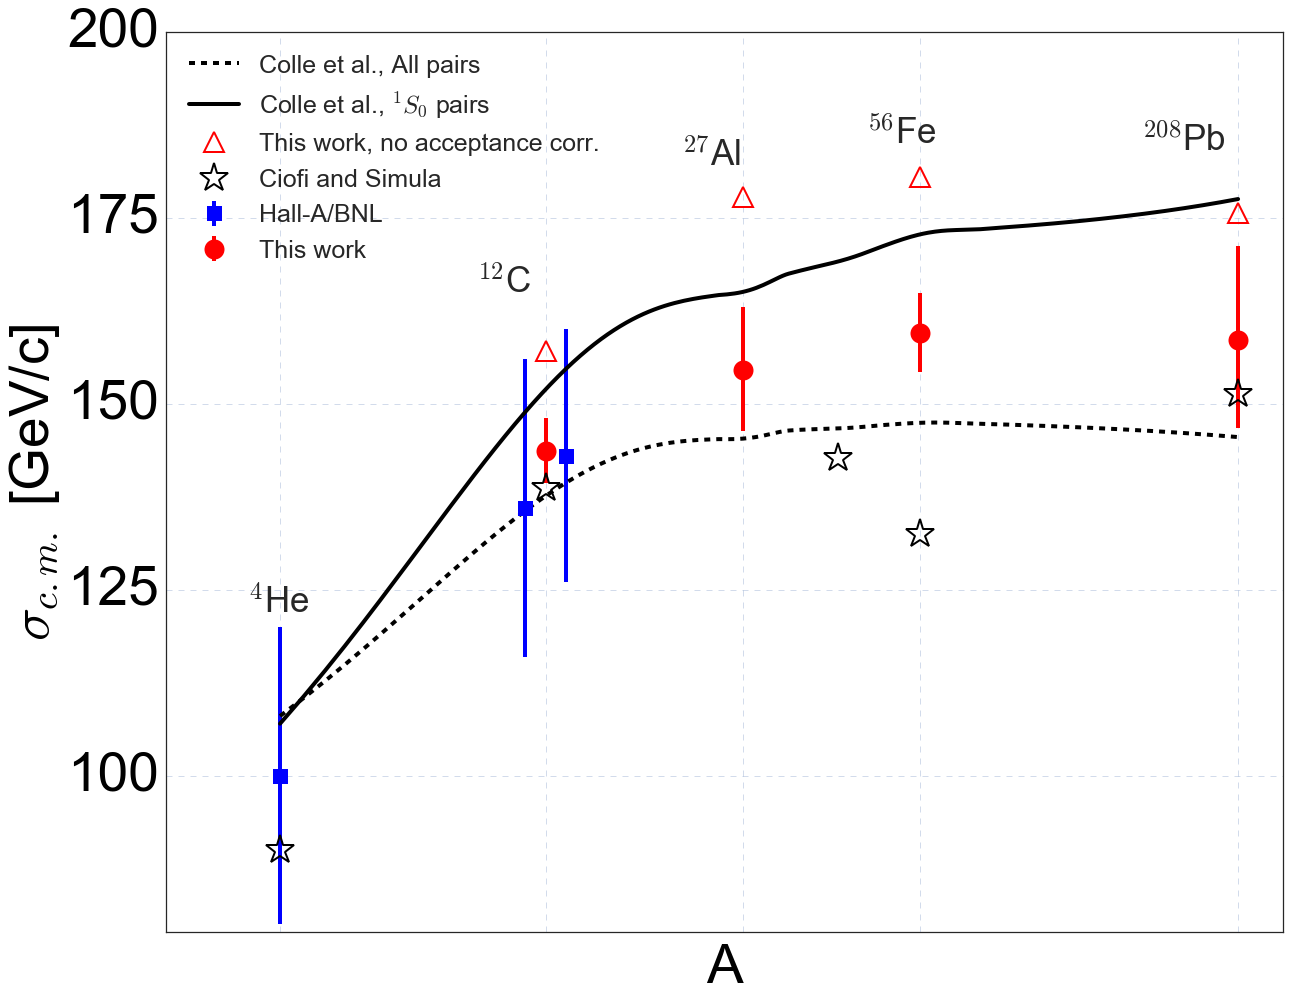

In [20]:
plot_A_depdendence_sigma_t(data=cm_parameters_with_correction['PrecFiducials']
                           ,figsize=(18,14)
                           ,do_stat_uncertainties=False,do_sys_uncertainties=False)

# compare mean(z) linear in $p_{miss}$ (slope$\times(p_{miss}-0.3)$) with 5 $\times \Delta_{measured}$

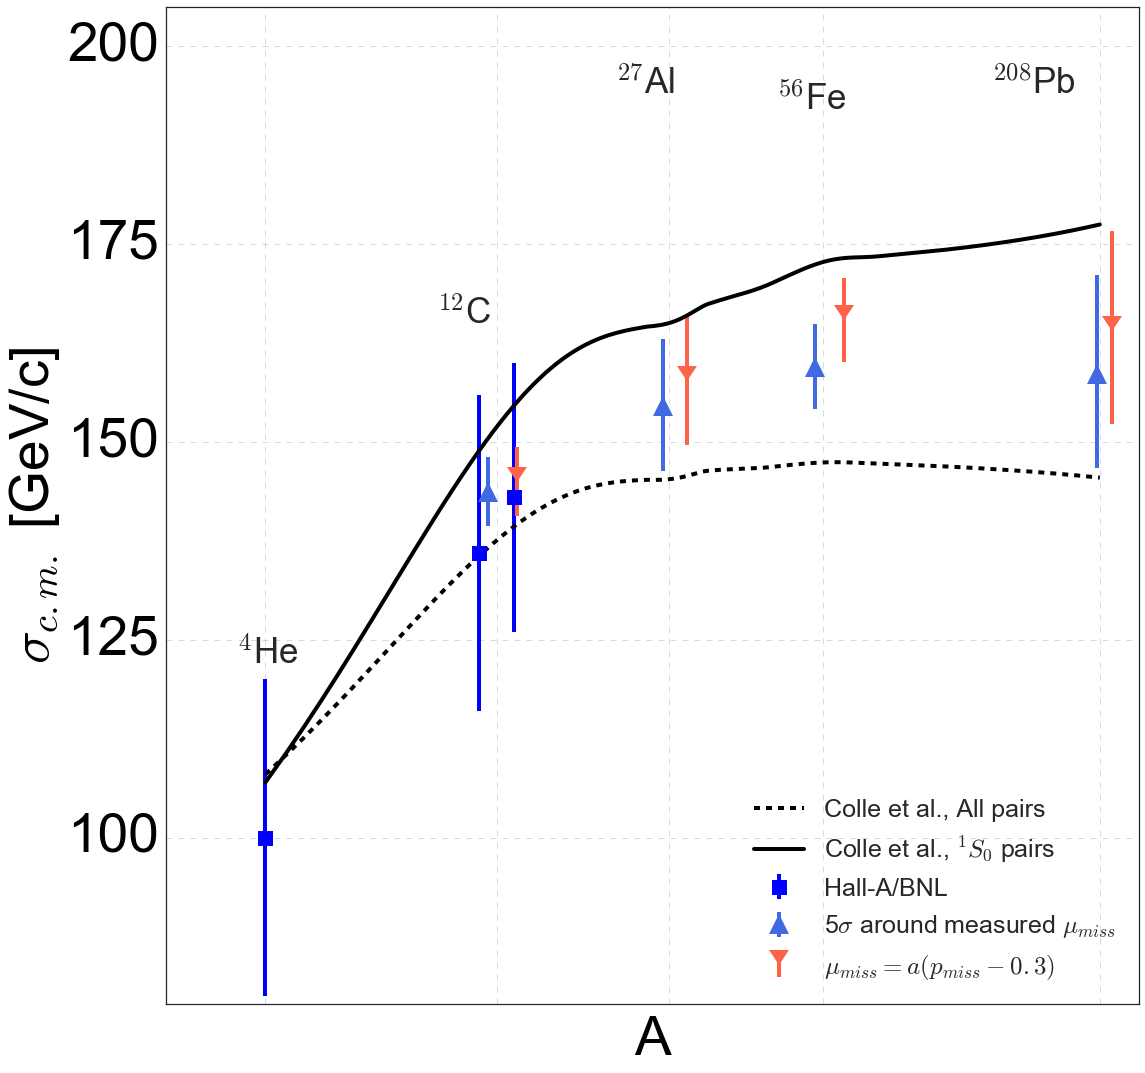

In [22]:
extraname="_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured"
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,194),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(125,194), }),do_Ciofi=False)
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'], ax=ax,Ashift=[-0.5,-0.7,-2,-3], label='5$\\sigma$ around measured $\\mu_{miss}$', color='royalblue',markersize=20  )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'], ax=ax,Ashift=[1.2,2.5,6,12] ,direction='t'+extraname, label='$\\mu_{miss}=a(p_{miss}-0.3)$',color='tomato',markersize=20 , marker=7 )
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()

# what happens for generation of a fixed $\mu_z$ in the measured values?

In [23]:
Fiducials = "PrecFiducials"
for extraname in ["fixed_meanZmeasured"]:
    for target in ['C','Al','Fe','Pb']:#{
        test_name = "sims_300Pmiss600_"+target+"_"+Fiducials+extraname
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/fixed_meanZmeasured_"+target+'_12150.csv')
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

12150 events in  sims_300Pmiss600_C_PrecFiducialsfixed_meanZmeasured
12150 events in  sims_300Pmiss600_Al_PrecFiducialsfixed_meanZmeasured
12150 events in  sims_300Pmiss600_Fe_PrecFiducialsfixed_meanZmeasured
12150 events in  sims_300Pmiss600_Pb_PrecFiducialsfixed_meanZmeasured


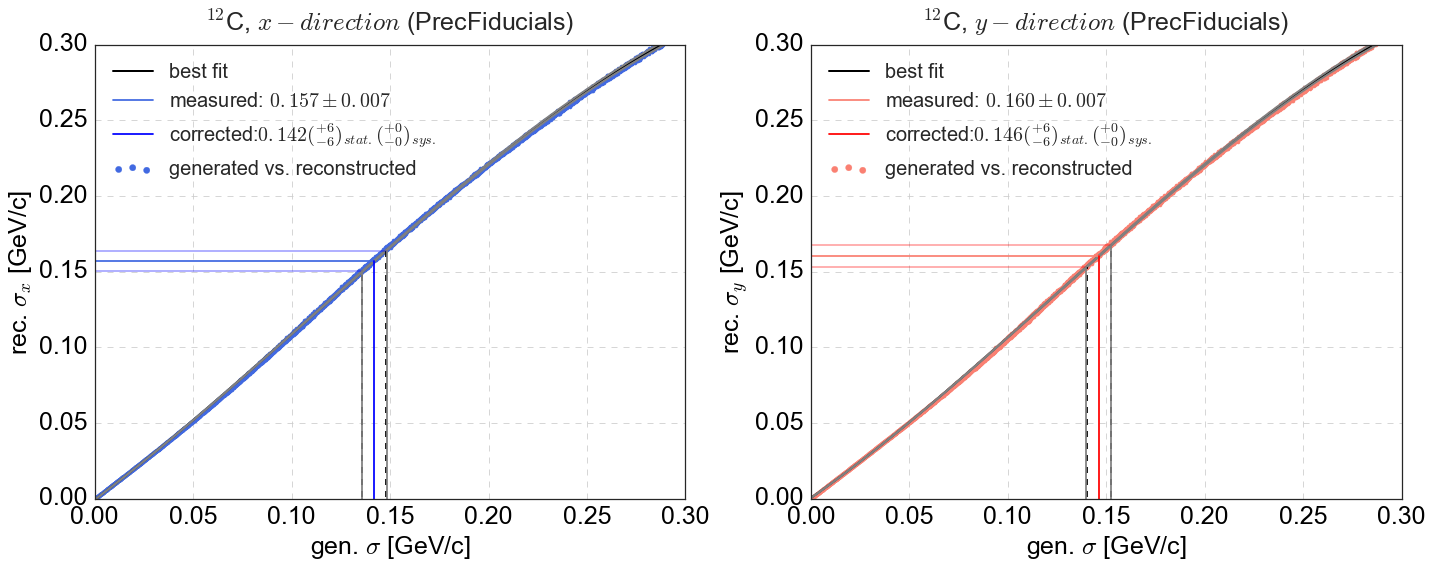

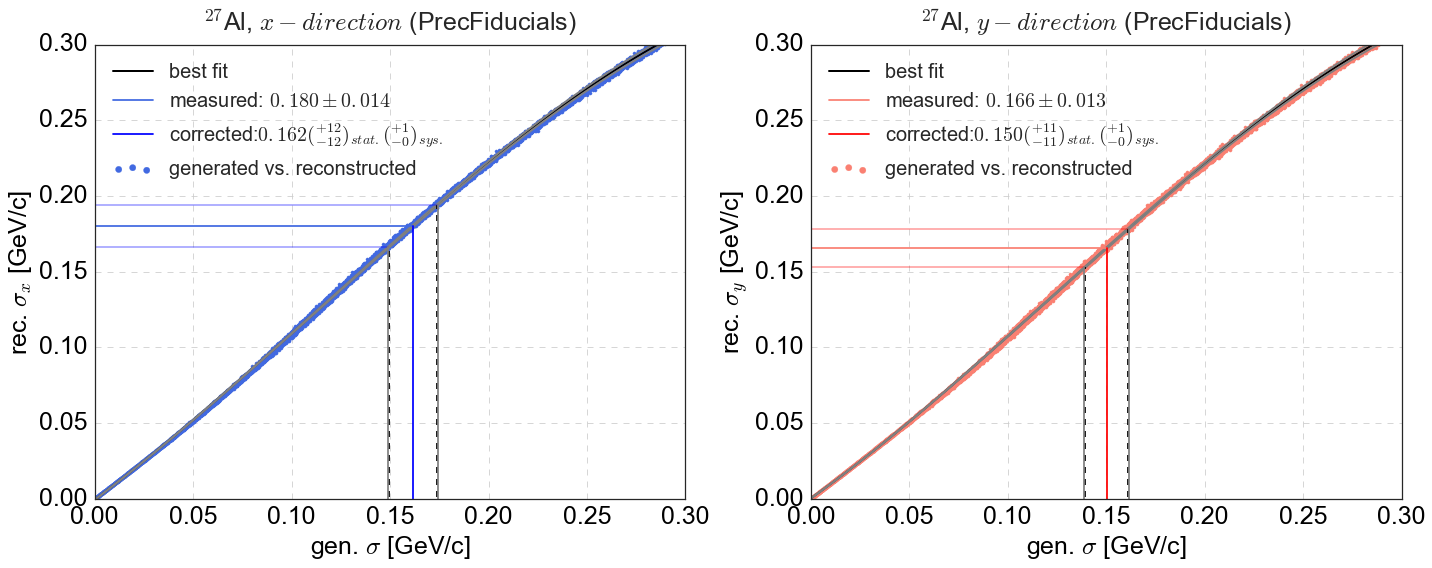

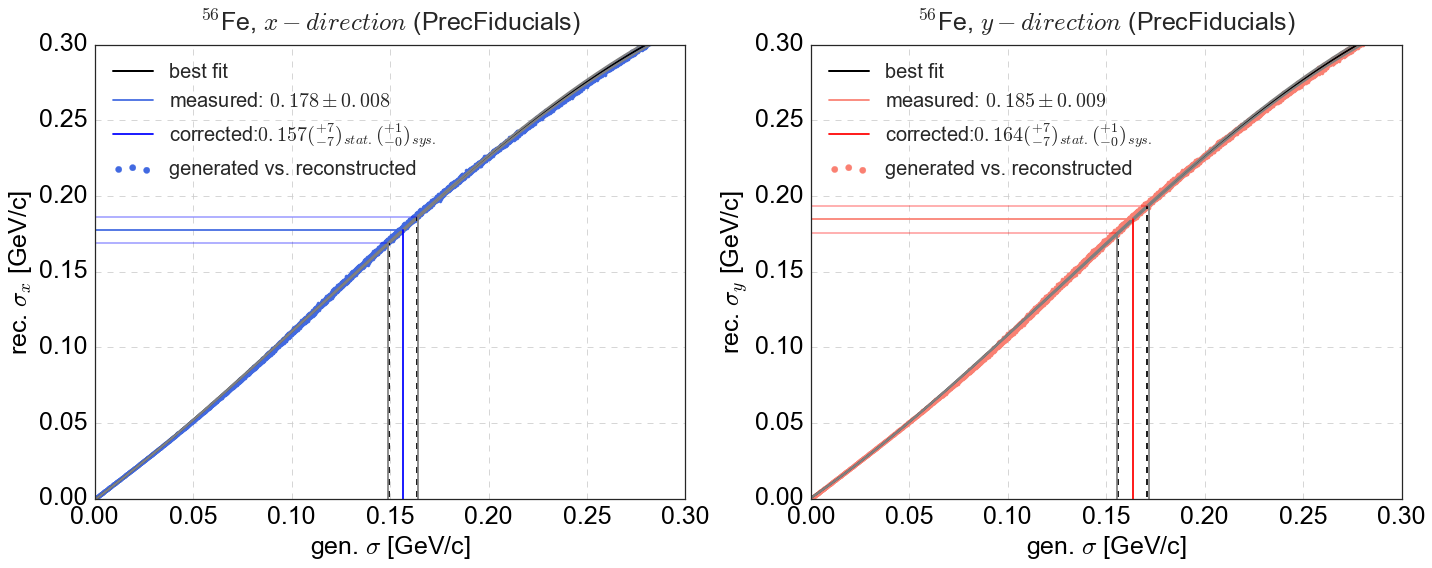

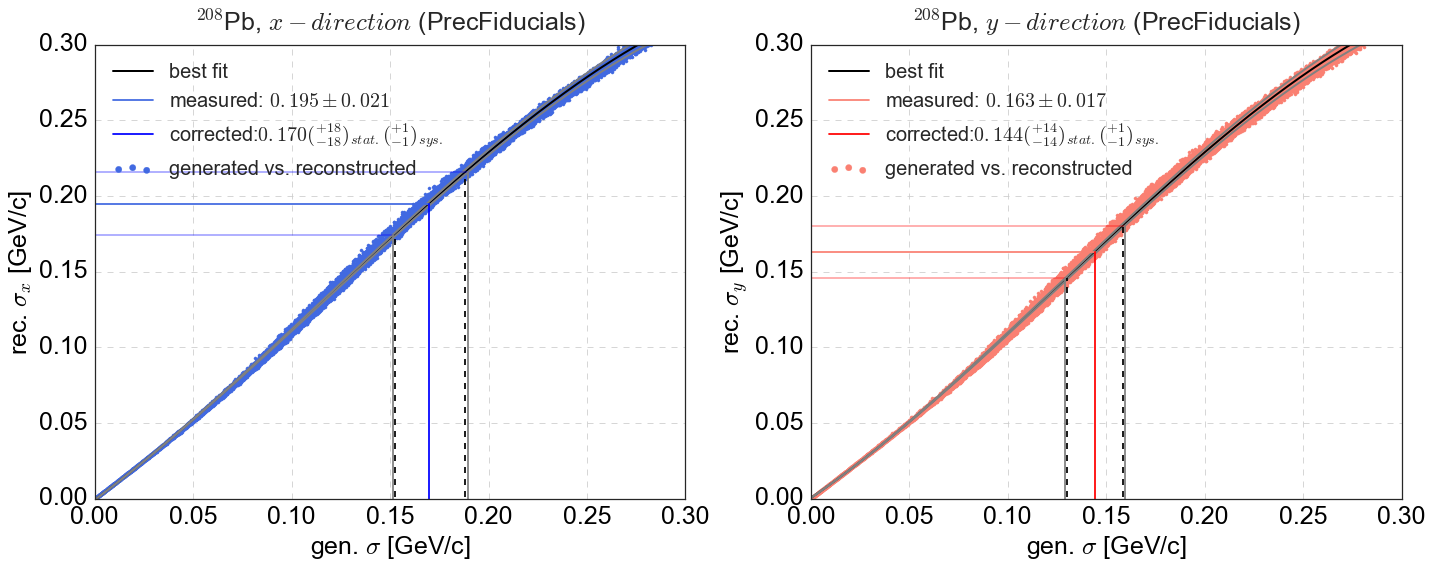

In [26]:
poly_degree = 3 # fit polynomial degree
confidence_interval = 0.68 # band around fit
Fiducials = "PrecFiducials"
extraname = "fixed_meanZmeasured"
for A,target,Neep,Neepp in zip([12,27,56,208]
                                   ,['C','Al','Fe','Pb']
                                   ,[7598,2573,8558,2635]
                                   ,[266,88,227,45]
                       ):#{

    test_name = "sims_300Pmiss600_"+target+"_"+Fiducials+extraname
    simulations_results=simulation_results[test_name]
    good_results = simulations_results[(simulations_results['gen_SigmaZ']>0)
                                           &(simulations_results['rec_sigma_x']>0)
                                           &(simulations_results['rec_sigma_y']>0)                                                                                    
                                           &(simulations_results['rec_sigma_z']>0)
                                           &(simulations_results['rec_mean_x']>-0.9)
                                           &(simulations_results['rec_mean_y']>-0.9)                                                                                   
                                           &(simulations_results['rec_mean_x']>-0.9)
                                          ]
    fig=plt.figure(figsize=(20,8))    
    ax=fig.add_subplot(1,2,1)    
    corr_sx = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials                                                           
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='x'                                                           
                                                           ,colors=['blue','royalblue']);

    ax=fig.add_subplot(1,2,2)    
    corr_sx = plot_cm_direction(simulations_results=good_results
                                                           ,Fiducials=Fiducials                                                                                                                                                                                 
                                                           ,ax=ax,s=10                                                           
                                                           ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                           
                                                           ,A=A,direction='y'                                                           
                                                           ,colors=['red','salmon']);                        
    
    plt.tight_layout()           